In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [2]:
import sys

pth_apple = "/Users/josesanchez/Desktop/Code/GitHub/StockPrediction/FileBase"
pth_win = "/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase"
sys.path.append(pth_win)


from root_functions import add_indicators, up_down, full_prediction, full_prediction_binary, result

## Descarga datos y creación dataset

In [3]:
sample_per = 10000
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1d'

In [4]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [5]:
#Añadimos indicadores

ema1=200
ema2=50
ema3=20

data_base = add_indicators(database)

#Añadimos columna up_down
data_base = up_down(data_base)

#Listado indicadores
data_base.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'log_ret', 'Up_Down'],
      dtype='object')

In [6]:
#Hacemos un shift a la columna Up_Down para tener el signo de la tendencia de la siguiente vela
data_base['Up_Down'] = data_base['Up_Down'].shift(-1)

data_base.dropna(inplace=True)

In [7]:
#Filtramos las columnas que nos interesan para obtener el dataset de trabajo
db = data_base.copy()


data = db[['Up_Down','log_ret','Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR']]


cols = data.columns

In [8]:
#Añadimos un filtro de outliers (por encima de 3 desviaciones quitamos el valor)

filt1 = np.abs(stats.zscore(data['log_ret'])) < 3
filt2 = np.abs(stats.zscore(data['log_ret'])) < 3

filt = (filt1 & filt2)

data = data[filt]

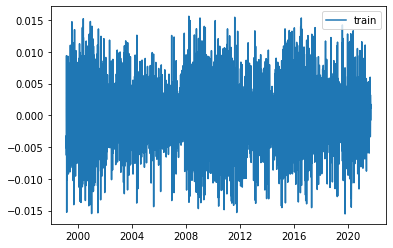

In [9]:
plt.plot(data['log_ret'], label='train')
plt.legend()
plt.show()

In [10]:
data.reset_index(inplace=True)
data.drop(columns=data.columns[0], inplace=True)

## Preparacion datos para el LSTM

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5786 entries, 0 to 5785
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Up_Down    5786 non-null   float64
 1   log_ret    5786 non-null   float64
 2   Open       5786 non-null   float64
 3   High       5786 non-null   float64
 4   Low        5786 non-null   float64
 5   Close      5786 non-null   float64
 6   Adj Close  5786 non-null   float64
 7   Volume     5786 non-null   int64  
 8   200ema     5786 non-null   float64
 9   50ema      5786 non-null   float64
 10  20ema      5786 non-null   float64
 11  14-high    5786 non-null   float64
 12  14-low     5786 non-null   float64
 13  %K         5786 non-null   float64
 14  %D         5786 non-null   float64
 15  RSI        5786 non-null   float64
 16  MACD       5786 non-null   float64
 17  MACDh      5786 non-null   float64
 18  MACDs      5786 non-null   float64
 19  CCI        5786 non-null   float64
 20  PSAR    

In [12]:
#Convertimos todas las columnas a valor numerico
data = data.apply(pd.to_numeric)


#Escalamos los valores con un MinMaxScaler

data['200ema'] = data['200ema'].pct_change()
data['50ema'] = data['50ema'].pct_change()
data['20ema'] = data['20ema'].pct_change()

data.dropna(inplace=True)

values = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

values = scaled

#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(4628, 1, 26) (4628,) (578, 1, 26) (578,) (579, 1, 26) (579,)


## Creamos el modelo

In [13]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(Dense(32, activation='LeakyReLU', kernel_initializer='he_uniform' ,input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(LSTM(128, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(256, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(128, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())



model.add(Dense(32, activation='LeakyReLU'))



model.add(Dense(1, activation='sigmoid'))




In [14]:
int(train_X.shape[0]/2)

2314

In [15]:
epochs = 100
train_size = train_X.shape[0]
batch_size = 64

initial_learning_rate = 0.1
final_learning_rate = 0.000001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

opt = SGD(learning_rate = lr_schedule )

In [16]:

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             864       
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            82432     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256)            1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 128)            5

In [18]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=epochs, batch_size = batch_size, validation_data=(val_X, val_y), verbose=2)

Epoch 1/100
73/73 - 4s - loss: 0.7251 - accuracy: 0.5292 - val_loss: 0.6932 - val_accuracy: 0.4948
Epoch 2/100
73/73 - 0s - loss: 0.6861 - accuracy: 0.5532 - val_loss: 0.6935 - val_accuracy: 0.5052
Epoch 3/100
73/73 - 0s - loss: 0.6771 - accuracy: 0.5700 - val_loss: 0.6937 - val_accuracy: 0.5052
Epoch 4/100
73/73 - 0s - loss: 0.6674 - accuracy: 0.5841 - val_loss: 0.6945 - val_accuracy: 0.5052
Epoch 5/100
73/73 - 0s - loss: 0.6641 - accuracy: 0.5797 - val_loss: 0.6972 - val_accuracy: 0.5052
Epoch 6/100
73/73 - 0s - loss: 0.6596 - accuracy: 0.5968 - val_loss: 0.6943 - val_accuracy: 0.5052
Epoch 7/100
73/73 - 0s - loss: 0.6553 - accuracy: 0.5994 - val_loss: 0.6839 - val_accuracy: 0.5242
Epoch 8/100
73/73 - 0s - loss: 0.6498 - accuracy: 0.6154 - val_loss: 0.7085 - val_accuracy: 0.5208
Epoch 9/100
73/73 - 0s - loss: 0.6504 - accuracy: 0.6016 - val_loss: 0.6199 - val_accuracy: 0.6799
Epoch 10/100
73/73 - 0s - loss: 0.6446 - accuracy: 0.6150 - val_loss: 0.6496 - val_accuracy: 0.5900
Epoch 11/

73/73 - 0s - loss: 0.6080 - accuracy: 0.6612 - val_loss: 0.5867 - val_accuracy: 0.6869
Epoch 84/100
73/73 - 0s - loss: 0.6049 - accuracy: 0.6763 - val_loss: 0.5867 - val_accuracy: 0.6851
Epoch 85/100
73/73 - 0s - loss: 0.6076 - accuracy: 0.6651 - val_loss: 0.5868 - val_accuracy: 0.6886
Epoch 86/100
73/73 - 0s - loss: 0.6043 - accuracy: 0.6692 - val_loss: 0.5867 - val_accuracy: 0.6869
Epoch 87/100
73/73 - 0s - loss: 0.6037 - accuracy: 0.6675 - val_loss: 0.5866 - val_accuracy: 0.6869
Epoch 88/100
73/73 - 0s - loss: 0.6048 - accuracy: 0.6722 - val_loss: 0.5866 - val_accuracy: 0.6851
Epoch 89/100
73/73 - 0s - loss: 0.6058 - accuracy: 0.6672 - val_loss: 0.5866 - val_accuracy: 0.6851
Epoch 90/100
73/73 - 0s - loss: 0.6063 - accuracy: 0.6664 - val_loss: 0.5867 - val_accuracy: 0.6869
Epoch 91/100
73/73 - 0s - loss: 0.6074 - accuracy: 0.6642 - val_loss: 0.5869 - val_accuracy: 0.6851
Epoch 92/100
73/73 - 0s - loss: 0.6047 - accuracy: 0.6685 - val_loss: 0.5867 - val_accuracy: 0.6851
Epoch 93/100


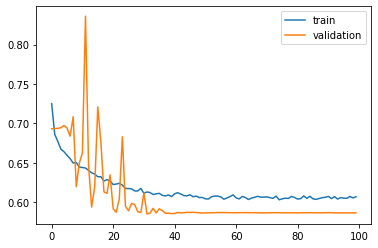

In [19]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

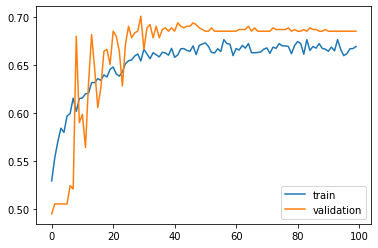

In [20]:
#Generamos plot con los resultados
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

## Resultados con valores de test

In [21]:
# make a prediction
yhat = model.predict(test_X)

In [22]:
inv_y, inv_yhat = full_prediction(yhat, test_X, test_y)

In [23]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_y = scaler.inverse_transform(inv_y)


inv_yhat_df = pd.DataFrame(data=inv_yhat, columns=cols)
inv_y_df = pd.DataFrame(data=inv_y, columns=cols)

In [24]:
res = result(inv_yhat, inv_y)



res['Diff'] = np.where(res['Up_Down_yhat'] == res['Up_Down_y'] , 'Acierto', 'Error')

res['Diff'].value_counts()

print(res['Diff'].value_counts())
print()
per = res['Diff'].value_counts()['Acierto']/(res['Diff'].value_counts()['Acierto']+res['Diff'].value_counts()['Error'])
print(f'% acierto: {per}')

Acierto    388
Error      191
Name: Diff, dtype: int64

% acierto: 0.6701208981001727
